Let's play a game! The SMILES string must be exactly 3 characters long, and only single bonds are allowed. What is the highest molecular weight (MW) you can achieve? Use only C, N, and O to find the valid SMILES with the highest MW.

## Direct search

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import itertools

# Possible characters for SMILES
atoms = ["C", "N", "O"]

# Generate all possible SMILES combinations
possible_smiles = set()
for comb in itertools.product(atoms, repeat=3):
    smiles = "".join(comb)
    if len(smiles) == 3:
        possible_smiles.add(smiles)
print("Check the combinations: \n")
print(possible_smiles)
print(len(possible_smiles))

# Validate SMILES and find highest MW
best_smiles = None
highest_mw = 0

for smi in possible_smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol:  # Check if valid
        mw = Descriptors.MolWt(mol)
        if mw > highest_mw:
            highest_mw = mw
            best_smiles = smi

print(f"Best SMILES: {best_smiles}, Highest MW: {highest_mw}")


{'NON', 'CON', 'NNN', 'NCN', 'CNC', 'ONC', 'NCC', 'NOC', 'CCN', 'OOO', 'COC', 'NCO', 'CNN', 'OOC', 'CCC', 'OON', 'NNO', 'NOO', 'CNO', 'ONN', 'COO', 'OCN', 'ONO', 'CCO', 'NNC', 'OCO', 'OCC'}
27
Best SMILES: OOO, Highest MW: 50.013000000000005


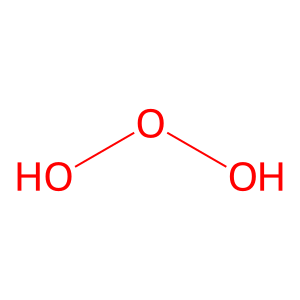

In [13]:
from IPython.display import display
from rdkit import Chem
from rdkit.Chem import Draw

# Convert SMILES to RDKit molecules
mol = Chem.MolFromSmiles(best_smiles)

# Generate the image
img = Draw.MolToImage(mol, size=(300, 300))

# Display in Jupyter Notebook
display(img)

## RL method

Reinforcement learning (RL) can be used to solve this problem, especially if you generalize it beyond brute-force searching. Instead of iterating through all possible combinations, RL can learn to generate the optimal SMILES with the highest molecular weight efficiently.

Below, we will use Q-learning to solve the same problem.

In [27]:
import random
import pickle  # For saving and loading the model
from rdkit import Chem
from rdkit.Chem import Descriptors

# Allowed elements
elements = ["C", "N", "O"]
# SMILES length constraint
max_length = 3


# Molecular Environment
class MolecularEnvironment:
    def __init__(self):
        self.current_smiles = []
    
    def reset(self):
        """Resets the environment (clears SMILES string)."""
        self.current_smiles = []
        return ""

    def step(self, action):
        """Takes an action (adds an element) and returns new state, reward, and done flag."""
        self.current_smiles.append(elements[action])
        new_state = "".join(self.current_smiles)
        done = len(self.current_smiles) == max_length  # Stop when 3 characters are reached
        reward = self.get_molecular_weight(new_state) if done else 0
        return new_state, reward, done

    @staticmethod
    def get_molecular_weight(smiles):
        """Calculates molecular weight using RDKit. Returns -10 for invalid molecules."""
        mol = Chem.MolFromSmiles(smiles)
        return Descriptors.MolWt(mol) if mol else -10  # Penalize invalid SMILES


# Q-learning Agent
class Agent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.2):
        self.q_table = {}  # State-action values
        self.alpha = alpha  # Learning rate (how much new information influences past values)
        self.gamma = gamma  # Discount factor (importance of future rewards)
        self.epsilon = epsilon  # Exploration rate

def train_molgen_highMW(agent, episodes=10):
    """Trains the agent using Q-learning to maximize molecular weight."""
    env = MolecularEnvironment()

    for episode in range(episodes):
        state = env.reset()  # Start with an empty SMILES
        done = False
        
        while not done and len(state) < max_length:
            # Choose action (explore or exploit)
            if random.random() < agent.epsilon:
                action = random.choice(range(len(elements)))  # Random exploration
            else:
                action = max(range(len(elements)), key=lambda a: agent.q_table.get((state, a), 0))  # Exploitation
                
            new_state, reward, done = env.step(action)

            # Q-learning update
            old_value = agent.q_table.get((state, action), 0)
            next_max = max([agent.q_table.get((new_state, a), 0) for a in range(len(elements))], default=0)
            # standard Bellman equation for Q-learning
            agent.q_table[(state, action)] = old_value + agent.alpha * (reward + agent.gamma * next_max - old_value)

            state = new_state  # Move to new state


# Start training
agent = Agent()
train_molgen_highMW(agent)

agent.q_table

{('', 0): 0.48764302152030004,
 ('C', 0): 1.1112444000000001,
 ('CC', 0): 11.950287,
 ('C', 2): 3.377502666,
 ('CO', 0): 18.86571619,
 ('', 2): 0.0,
 ('O', 0): 0.0,
 ('OC', 0): 4.6069,
 ('', 1): 0.0,
 ('N', 0): 0.0,
 ('NC', 0): 4.5085}

In [28]:
# Saves the trained Q-table
filename="q_table.pkl"
with open(filename, "wb") as f:
    pickle.dump(agent.q_table, f)
    
with open(filename, "rb") as f:
    agent.q_table = pickle.load(f)

# Loads the Q-table
# agent.q_table

In [29]:
# Run inference
def run_inference(agent):
    """Finds the SMILES with the highest molecular weight using the trained Q-table."""
    best_smiles = ""
    best_mw = -float("inf")
    env = MolecularEnvironment()

    for (state, action), value in agent.q_table.items():
        full_smiles = state + elements[action]
        if len(full_smiles) == max_length:
            mw = env.get_molecular_weight(full_smiles)
            if mw > best_mw:
                best_mw = mw
                best_smiles = full_smiles

    print(f"Best SMILES: {best_smiles}, Highest MW: {best_mw}")
    return best_smiles, best_mw

run_inference(agent)

Best SMILES: COC, Highest MW: 46.069


('COC', 46.069)

In [ ]:
# Run inference
def run_inference(agent):
    """Finds the SMILES with the highest molecular weight using the trained Q-table."""
    best_smiles = ""
    best_mw = -float("inf")
    env = MolecularEnvironment()
    max_value = 0

    for (state, action), value in agent.q_table.items():
        if value > max_value: # Choose best Q-value
            max_value = value
            full_smiles = state + elements[action]
            if len(full_smiles) == max_length:
                mw = env.get_molecular_weight(full_smiles)
                if mw > best_mw:
                    best_mw = mw
                    best_smiles = full_smiles

    print(f"Best SMILES: {best_smiles}, Highest MW: {best_mw}")
    return best_smiles, best_mw

run_inference(agent)

Best SMILES: COC, Highest MW: 46.069


('COC', 46.069)

If the iteration is small, the q-value is not optimized. When we searched the max q-value, the MW is sometimes not max. 

1. The same state-action pair can be updated multiple times as the agent learns.
2. Each update gradually moves Q-values toward the true expected return.
3. Q-values stabilize over time as learning progresses.